In [ ]:
#pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/Master_2/defi_3/trainSet-rle.csv'
folder_path = '/content/drive/MyDrive/Master_2/defi_3/dicom-images-train'
validation_path = '/content/drive/MyDrive/Master_2/defi_3/dicom-images-valid'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# chargement

In [ ]:
import os
import pandas as pd
import pydicom
import numpy as np
from tqdm import tqdm

# Charger le fichier CSV contenant les annotations
csv_path = '/content/drive/MyDrive/Master_2/defi_3/trainSet-rle.csv'
df = pd.read_csv(csv_path, sep=';')

# Charger les images DICOM
folder_path = '/content/drive/MyDrive/Master_2/defi_3/dicom-images-train'

# Fonction pour vérifier si le fichier DICOM existe
def file_exists(dicom_id):
    dicom_path = os.path.join(folder_path, f'{dicom_id}.dcm')
    return os.path.exists(dicom_path)

# Fonction pour lire une image DICOM et la convertir en tableau numpy
def load_dicom_image(image_id):
    dicom_path = os.path.join(folder_path, f'{image_id}.dcm')
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array
    image = image.astype(np.float32)  # Optionnel, selon le type d'image
    return image

# Liste des fichiers DICOM manquants
missing_files = []

# Charger les 40 premières images DICOM en vérifiant l'existence
images = []
for image_id in tqdm(df['ImageId'].head(40), desc="Chargement des images DICOM"):
    if file_exists(image_id):  # Vérifier si le fichier existe
        images.append(load_dicom_image(image_id))
    else:
        missing_files.append(image_id)

# Convertir les images en un tableau numpy
images = np.array(images)

# Affichage des fichiers manquants
if missing_files:
    print(f"Les fichiers suivants sont manquants : {missing_files}")
else:
    print("Toutes les images ont été chargées avec succès.")

# Affichage de la taille des données chargées
print(f"Nombre d'images chargées : {images.shape[0]}" if len(images) > 0 else "Aucune image chargée.")
print(f"Dimensions des images : {images.shape[1:]}" if len(images) > 0 else "Pas d'image à afficher.")

Chargement des images DICOM: 100%|██████████| 40/40 [00:00<00:00, 73.56it/s]


Les fichiers suivants sont manquants : ['1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090', '1.2.276.0.7230010.3.1.4.8323329.5782.1517875190.531042']
Nombre d'images chargées : 38
Dimensions des images : (1024, 1024)


# Prétraitement

Prétraitement des images: 100%|██████████| 38/38 [00:04<00:00,  8.00it/s]


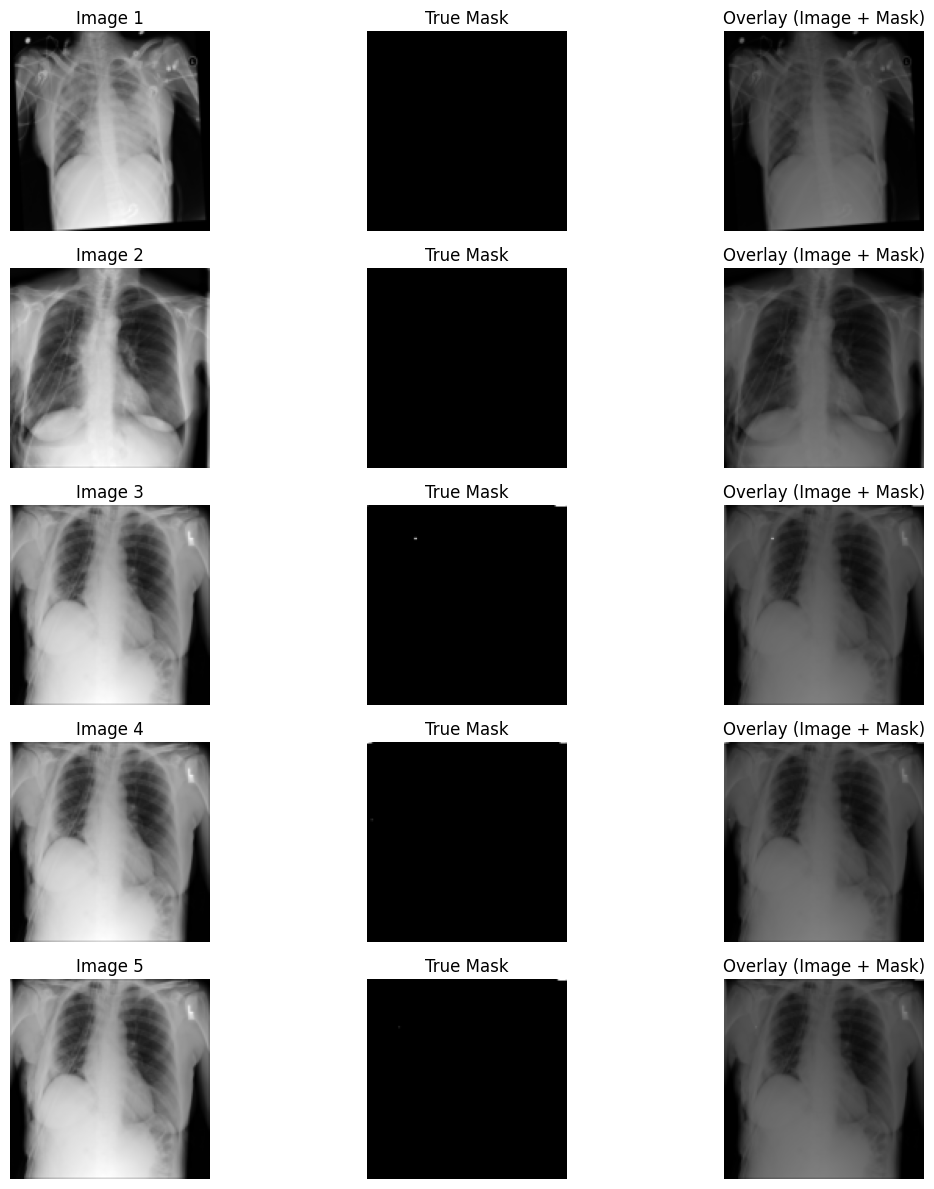

Taille des images traitées : (38, 128, 128, 3)
Taille des masques : (38, 128, 128)


In [ ]:
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize
import numpy as np

# Fonction de redimensionnement des images
def resize_image(image, target_size=(128, 128)):
    return resize(image, target_size, mode='constant', preserve_range=True)

# Fonction de normalisation des images
def normalize_image(image):
    scaler = MinMaxScaler()
    return scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)

# Fonction pour encoder les pixels RLE en masque binaire
def rle_to_mask(rle, height=1024, width=1024):
    if rle == '-1':  # Pas de maladie
        return np.zeros((height, width), dtype=np.uint8)

    # Convertir le RLE en une liste d'indices
    rle_numbers = list(map(int, rle.split()))
    mask = np.zeros(height * width, dtype=np.uint8)

    # Remplir le masque
    for start, length in zip(rle_numbers[::2], rle_numbers[1::2]):
        mask[start:start+length] = 1

    # Reshaper le masque à la taille d'image
    return mask.reshape((height, width))

# Fonction de redimensionnement des masques
def resize_mask(mask, target_size=(128, 128)):
    return resize(mask, target_size, mode='constant', preserve_range=True)

# Prétraitement des images et des masques
processed_images = []
masks = []

for idx in tqdm(range(len(images)), desc="Prétraitement des images"):
    # Redimensionner et normaliser l'image
    image_resized = resize_image(images[idx], target_size=(128, 128))
    image_normalized = normalize_image(image_resized)

    # Ajouter l'image traitée à la liste
    processed_images.append(np.stack([image_normalized] * 3, axis=-1))

    # Encoder le masque à partir du RLE et redimensionner à 128x128
    rle = df.iloc[idx]['EncodedPixels']
    mask = rle_to_mask(rle)
    mask_resized = resize_mask(mask, target_size=(128, 128))  # Redimensionner le masque
    masks.append(mask_resized)

# Convertir les listes en tableaux numpy
processed_images = np.array(processed_images)
masks = np.array(masks)

# Affichage des 5 premières images et masques pour vérifier
n = 5  # Nombre d'images à afficher
fig, axes = plt.subplots(n, 3, figsize=(12, 12))
for i in range(n):
    axes[i, 0].imshow(processed_images[i])  # Image redimensionnée
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(masks[i], cmap='gray')  # True Mask (masque réel)
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(processed_images[i], cmap='gray')  # Image redimensionnée
    axes[i, 2].imshow(masks[i], cmap='gray', alpha=0.5)  # Overlay du masque sur l'image
    axes[i, 2].set_title("Overlay (Image + Mask)")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Vérification des dimensions
print(f"Taille des images traitées : {processed_images.shape}")
print(f"Taille des masques : {masks.shape}")

# Modèle

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

def resize_image(image, target_size=(128, 128)):
    return resize(image, target_size, mode='constant', preserve_range=True)

def normalize_image(image):
    scaler = MinMaxScaler()
    return scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)

def preprocess_for_classification(image):
    image_resized = resize_image(image, target_size=(128, 128))
    image_normalized = normalize_image(image_resized)
    image_rgb = np.stack([image_normalized] * 3, axis=-1)
    return image_rgb

def rle_to_mask(rle, height=128, width=128):
    if rle == '-1':
        return np.zeros((height, width), dtype=np.uint8)
    rle_numbers = list(map(int, rle.split()))
    mask = np.zeros(height * width, dtype=np.uint8)
    for start, length in zip(rle_numbers[::2], rle_numbers[1::2]):
        mask[start:start+length] = 1
    return mask.reshape((height, width))

df['EncodedPixels'] = df['EncodedPixels'].fillna('-1')
labels_classification = df['EncodedPixels'].apply(lambda x: 0 if x == '-1' else 1).values

num_images = len(images)
processed_images = []
masks = []
for idx in range(num_images):
    image_resized = resize_image(images[idx], target_size=(128, 128))
    image_normalized = normalize_image(image_resized)
    processed_images.append(np.stack([image_normalized] * 3, axis=-1))
    rle = df.iloc[idx]['EncodedPixels']
    masks.append(rle_to_mask(rle))

processed_images_classification = np.array(processed_images)
masks = np.array(masks)

X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(processed_images_classification, labels_classification[:num_images], test_size=0.2, random_state=42)
X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(processed_images_classification, masks, test_size=0.2, random_state=42)

def create_classification_model(input_shape):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
classification_model = create_classification_model(input_shape)

In [ ]:
history_classification = classification_model.fit(
    X_train_class,
    y_train_class,
    epochs=10,
    batch_size=8,
    validation_data=(X_val_class, y_val_class)
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6017 - loss: 0.8304 - val_accuracy: 0.8750 - val_loss: 0.2781
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5767 - loss: 0.9209 - val_accuracy: 0.3750 - val_loss: 0.9218
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5300 - loss: 1.0438 - val_accuracy: 0.8750 - val_loss: 0.1771
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8367 - loss: 0.4744 - val_accuracy: 1.0000 - val_loss: 0.1870
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7908 - loss: 0.9009 - val_accuracy: 0.3750 - val_loss: 1.3900
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5958 - loss: 0.7485 - val_accuracy: 0.8750 - val_loss: 0.3030
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7383 - loss: 0.7181 - val_accuracy: 1.0000 - val_loss: 0.1001
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7017 - loss: 0.7351 - val_accuracy: 0.3750 - val_loss: 1.1555
Epoch 9/10


In [ ]:
segmentation_model = create_unet_model(input_shape)
history_segmentation = segmentation_model.fit(
    X_train_seg,
    y_train_seg,
    epochs=10,
    batch_size=8,
    validation_data=(X_val_seg, y_val_seg)
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step - accuracy: 0.5254 - loss: 0.5652 - val_accuracy: 0.9952 - val_loss: 0.0700
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.9970 - loss: 0.0455 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.9976 - loss: 0.0382 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9971 - loss: 0.0471 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 10s/step - accuracy: 0.9967 - loss: 0.0525 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.9971 - loss: 0.0460 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 10s/step - accuracy: 0.9976 - loss: 0.0393 - val_accuracy: 0.9952 - val_loss: 0.0777
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.9975 - loss: 0.0403 - val_accuracy: 0.9952 - val_loss: 0.0777
Epo

# Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0546
Classification Loss: 0.05459313467144966
Classification Accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Accuracy Score: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9952 - loss: 0.0777
Segmentation Loss: 0.07771798968315125
Segmentation Accuracy: 0.99517822265625
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Mean Jaccard Index for Segmentation: 0.0


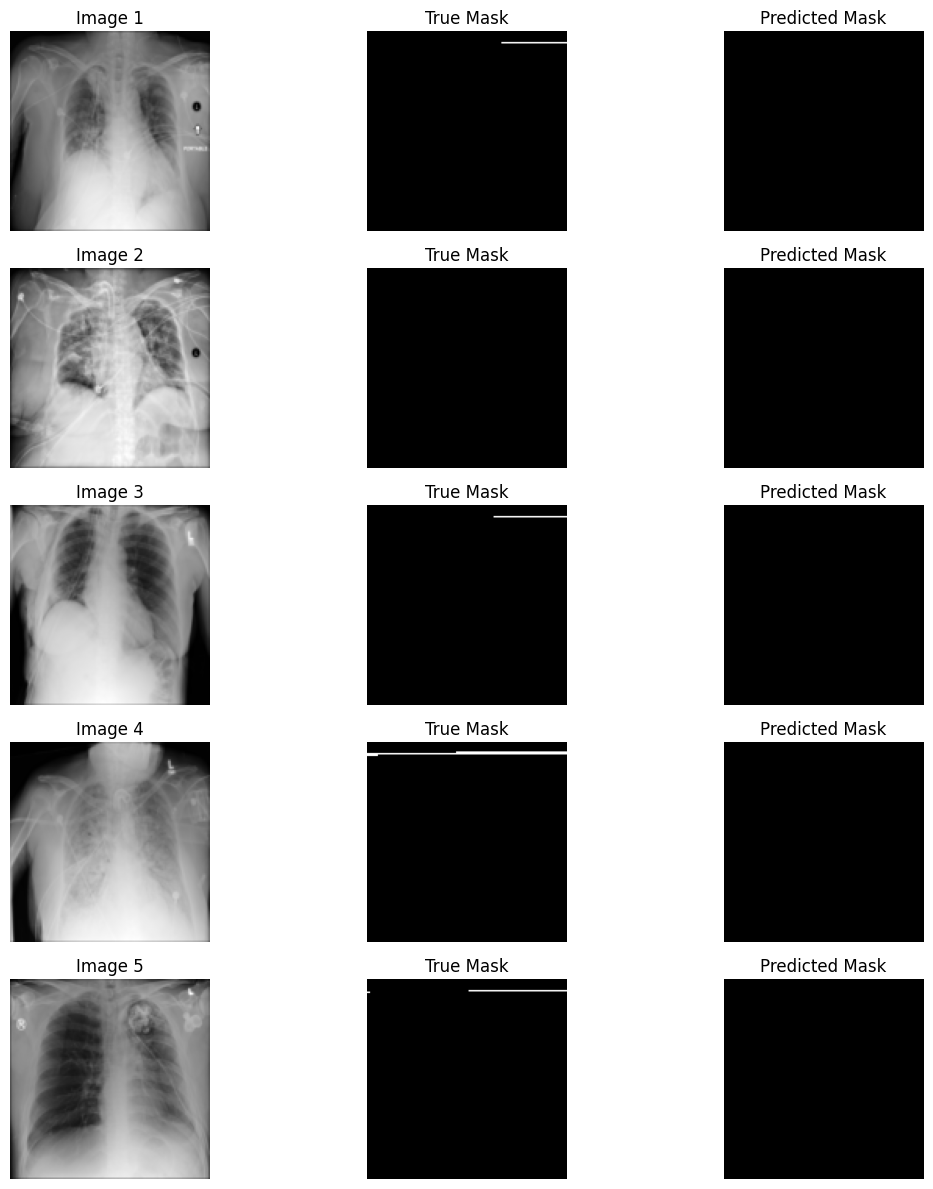

In [ ]:
from sklearn.metrics import accuracy_score, jaccard_score
import matplotlib.pyplot as plt

# Évaluation du modèle de classification
classification_loss, classification_accuracy = classification_model.evaluate(X_val_class, y_val_class)
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {classification_accuracy}")

# Prédictions pour le modèle de classification
y_pred_class = classification_model.predict(X_val_class)
y_pred_class = (y_pred_class > 0.5).astype(int)

# Calcul des métriques pour le modèle de classification
classification_accuracy_score = accuracy_score(y_val_class, y_pred_class)
print(f"Classification Accuracy Score: {classification_accuracy_score}")

# Évaluation du modèle de segmentation
segmentation_loss, segmentation_accuracy = segmentation_model.evaluate(X_val_seg, y_val_seg)
print(f"Segmentation Loss: {segmentation_loss}")
print(f"Segmentation Accuracy: {segmentation_accuracy}")

# Prédictions pour le modèle de segmentation
y_pred_seg = segmentation_model.predict(X_val_seg)
y_pred_seg = (y_pred_seg > 0.5).astype(np.uint8)

# Calcul du Jaccard Index pour le modèle de segmentation
def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    return intersection / union if union != 0 else 0

jaccard_scores = []
for i in range(len(y_pred_seg)):
    jaccard_scores.append(jaccard_index(y_val_seg[i], y_pred_seg[i]))

mean_jaccard = np.mean(jaccard_scores)
print(f"Mean Jaccard Index for Segmentation: {mean_jaccard}")

# Sauvegarde des modèles
classification_model.save('/content/drive/MyDrive/Master_2/defi_3/classification_model.h5')
segmentation_model.save('/content/drive/MyDrive/Master_2/defi_3/segmentation_model.h5')

# Nombre d'images à afficher dans la grille
n = 5  # Nombre d'images à afficher
fig, axes = plt.subplots(n, 3, figsize=(12, 12))
for i in range(n):
    axes[i, 0].imshow(X_val_seg[i])  # Image redimensionnée
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(y_val_seg[i], cmap='gray')  # True Mask (masque réel)
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_pred_seg[i], cmap='gray')  # Predicted Mask (masque prédit)
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# validation

In [ ]:
# Affichage des images avec les résultats de classification
n = 5  # Nombre d'images à afficher
fig, axes = plt.subplots(n, 2, figsize=(12, 12))
for i in range(n):
    axes[i, 0].imshow(validation_images[i])  # Image redimensionnée
    axes[i, 0].set_title(f"Image {validation_image_ids[i]}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(validation_images[i], cmap='gray')  # Affichage de l'image
    axes[i, 1].set_title("Prédiction: " + ('Malade' if y_pred_class[i] == 1 else 'Sain'))
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
